<a href="https://colab.research.google.com/github/TerMinator-spec/Uknowme/blob/master/Match_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True )

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/trainset.zip -d /content

In [3]:
import os
subdirs = [x[0] for x in os.walk('/content/trainset/')]
#print(subdirs)
tcpyfrom=[] # get the paths of the directories which contain the images
for i in range(len(subdirs)):
  if(len(subdirs[i])>25):
    tcpyfrom.append(subdirs[i])

In [ ]:
tcpyfrom

In [ ]:
os.listdir('/content/trainset/0006/0006_0000625')

['0000007.jpg',
 '0000001.jpg',
 '0000005.jpg',
 '0006_0000625_script.jpg',
 '0000009.jpg',
 '0000002.jpg',
 '0000008.jpg',
 '0000004.jpg',
 '0000003.jpg']

In [5]:
X=[] # storing a single selfie from each directory

for i in range(len(tcpyfrom)):
  for j in range(len(os.listdir(tcpyfrom[i]))):
      if(len(os.listdir(tcpyfrom[i])[j])<13):
        X.append(tcpyfrom[i]+'/'+os.listdir(tcpyfrom[i])[j])
        break
      



In [6]:

y=[] # storing passport size original image from each directory
for i in range(len(tcpyfrom)):
  for j in range(len(os.listdir(tcpyfrom[i]))):
      
      if(len(os.listdir(tcpyfrom[i])[j])>13):
        y.append(tcpyfrom[i]+'/'+os.listdir(tcpyfrom[i])[j])
        break

In [7]:
len(y)==len(X)

True

In [ ]:
y[-20:]

In [8]:
#renaming the image
x=[]
for i in range(len(X)):
  src=X[i]
  amc=X[i][:-11]
  a=X[i][23:35]
  dest=amc+a+"_"+X[i][-11:]
  x.append(dest)
  os.rename(src, dest)

In [9]:
import os
import numpy as np
import shutil
import random

os.makedirs('/content/train_X/', exist_ok=True) # make the corresponding directories
os.makedirs('/content/train_y/', exist_ok=True)
for name in x:
    shutil.copy(name,'/content/train_X/')

for name in y:
    shutil.copy(name, '/content/train_y/')


In [ ]:
os.listdir('/content/train_y')

In [10]:
# image preprocessing
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# defining global variable path
image_path = "/content/train_X"

'''function to load folder into arrays and 
then it returns that same array'''
def loadImages(path):
    # Put files into lists and return them as one list of size 4
    image_files = sorted([os.path.join(path, file)
         for file in os.listdir(path) if file.endswith('.jpg')])
 
    return image_files

In [11]:
dat_x=loadImages(image_path)
dat_y=loadImages("/content/train_y")

In [12]:
len(dat_x)==len(dat_y)

True

In [16]:
# preprocess and resize the image to get back the torch tensor of the image
from PIL import Image
w=256
h=256
def preprocess(data):
    import torch
    img_t=[]
    for i in range(len(data)):      
          img = Image.open(data[i]) # use pillow to open a file
          img = img.resize((w, h)) # resize the file to 256x256
          img = img.convert('RGB') #convert image to RGB channe
          img = np.asarray(img)/255
          img = np.asarray(img).transpose(-1, 0, 1) # we have to change the dimensions from width x height x channel (WHC) to channel x width x height (CWH)
          img = torch.from_numpy(np.asarray(img)) # create the image tensor
          img_t.append(img)
    return img_t

In [58]:
xx=preprocess(dat_x)
yy=preprocess(dat_y)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


In [59]:
xx[0].shape

torch.Size([3, 256, 256])

In [22]:
from numpy import vstack
from numpy import sqrt

from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Sequential,Linear, Conv2d, MaxPool2d, BatchNorm2d, Flatten
from torch.nn import Sigmoid, ReLU
from torch.nn import Module
from torch.optim import SGD
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_
from torch.utils.data import TensorDataset
from torch import optim

In [8]:
class my_model(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(my_model, self).__init__()
        self.cnn_layers = Sequential(
            
            Conv2d(n_inputs, 64, kernel_size=7, stride=2),
            MaxPool2d(kernel_size=3, stride=2, padding=0),
            BatchNorm2d(64),
            ReLU(inplace=True),# Relu activation is used to avoid vanishing gradient problem
            
            Conv2d( 64, 64, kernel_size=1, stride=1),
            Conv2d( 64, 192, kernel_size=3, stride=1),
            BatchNorm2d(192),
            MaxPool2d(kernel_size=3, stride=2, padding=0),
            ReLU(inplace=True),
            
            Conv2d( 192, 192, kernel_size=1, stride=1),
            Conv2d( 192,384, kernel_size=3, stride=1),
            MaxPool2d(kernel_size=3, stride=2, padding=0),
            ReLU(inplace=True),
            
            Conv2d( 384, 384, kernel_size=1, stride=1),
            Conv2d( 384,256, kernel_size=3, stride=1),
            Conv2d( 256,256, kernel_size=1, stride=1),
            Conv2d( 256,256, kernel_size=3, stride=1),
            Conv2d( 256,256, kernel_size=1, stride=1),
            Conv2d( 256,256, kernel_size=3, stride=1),
            MaxPool2d(kernel_size=3, stride=2, padding=0),
            Flatten()

        )
        self.linear_layers = Sequential(
            Linear(256*3*3, 192),
            Linear(192, 128)
        )
        
    # forward propagate input
    def forward(self, X):
      
        X = self.cnn_layers(X)
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return X

In [67]:
model=my_model(3)

In [20]:
def train_model(xx, yy, model,epochs):
    # define the optimization
    
    criterion = MSELoss()# We are here calculating the euclidean distance squared between the selfie and the script image
    # after succesive training of the data the mse which we will get will act as the threshold for the clasification purposes
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9) # Choosing sgd with default parameters
    # enumerate epochs
    for epoch in range(epochs):
        
        Loss=0
        for i in range(len(xx)):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            img_x = xx[i].reshape(1, 3,w, h) # 128-d feature vector for selfie
            img_y = yy[i].reshape(1, 3,w, h) # 128-d feature vector for script image
            x1 = model(img_x.float())
            y1 = model(img_y.float())
            # calculate loss
            loss = criterion(x1,y1)
            Loss=Loss+loss
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        print("Epoch",epoch, "train Loss",Loss)

In [69]:
epochs=30
model=my_model(3)
# train the model
train_model(xx, yy, model,epochs)

Epoch 0 train Loss tensor(0.0114, grad_fn=<AddBackward0>)
Epoch 1 train Loss tensor(0.0089, grad_fn=<AddBackward0>)
Epoch 2 train Loss tensor(0.0077, grad_fn=<AddBackward0>)
Epoch 3 train Loss tensor(0.0069, grad_fn=<AddBackward0>)
Epoch 4 train Loss tensor(0.0064, grad_fn=<AddBackward0>)
Epoch 5 train Loss tensor(0.0059, grad_fn=<AddBackward0>)
Epoch 6 train Loss tensor(0.0056, grad_fn=<AddBackward0>)
Epoch 7 train Loss tensor(0.0053, grad_fn=<AddBackward0>)
Epoch 8 train Loss tensor(0.0051, grad_fn=<AddBackward0>)
Epoch 9 train Loss tensor(0.0049, grad_fn=<AddBackward0>)
Epoch 10 train Loss tensor(0.0047, grad_fn=<AddBackward0>)
Epoch 11 train Loss tensor(0.0045, grad_fn=<AddBackward0>)
Epoch 12 train Loss tensor(0.0044, grad_fn=<AddBackward0>)
Epoch 13 train Loss tensor(0.0042, grad_fn=<AddBackward0>)
Epoch 14 train Loss tensor(0.0041, grad_fn=<AddBackward0>)
Epoch 15 train Loss tensor(0.0040, grad_fn=<AddBackward0>)
Epoch 16 train Loss tensor(0.0039, grad_fn=<AddBackward0>)
Epoch 1

In [ ]:
#Loss after last epoch is 0.0030

In [2]:
import torch

In [78]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/img_dtct")

In [9]:
# Load the model
model=my_model(3)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/img_dtct"))

<All keys matched successfully>

In [ ]:
threshold_loss=0.0030/len(xx) # mse loss for two images greater than this threshold will be classified as unmatched else matched

In [17]:
# Let's visualize the image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
w=256
h=256
def show_img(path):
    img = Image.open(path) # use pillow to open a file
    img = img.resize((w, h)) # resize the file to 256x256
    img = img.convert('RGB') #convert image to RGB channe
    img = np.asarray(img)/255
    plt.imshow(img)

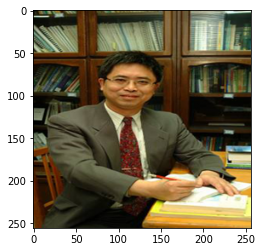

In [18]:

tst_img1='/content/trainset/0001/0001_0000255/0000005.jpg'
orig_img1='/content/trainset/0001/0001_0000255/0001_0000255_script.jpg'
show_img(tst_img1)

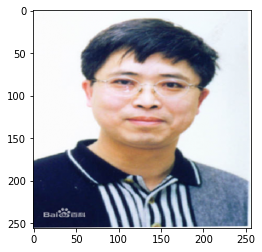

In [19]:
show_img(orig_img1)

In [21]:
def get_img(path):
  img = Image.open(path) # use pillow to open a file
  img = img.resize((w, h)) # resize the file to 256x256
  img = img.convert('RGB') #convert image to RGB channe
  img = np.asarray(img)/255
  img = np.asarray(img).transpose(-1, 0, 1) # we have to change the dimensions from width x height x channel (WHC) to channel x width x height (CWH)
  img = torch.from_numpy(np.asarray(img))
  return img

In [75]:
# Evaluate the results
def eval(path1, path2):
  xx = get_img(path1)
  yy = get_img(path2)
  img_x = xx.reshape(1, 3,w, h)
  img_y = yy.reshape(1, 3,w, h)
  x1 = model(img_x.float())
  y1 = model(img_y.float())
  # calculate loss
  criterion = MSELoss()
  loss = criterion(x1,y1)
  if(loss<=threshold_loss):
    print("Matched \n")
  else:
    print('Unmatched \n')
  print(loss)
  print("\n")


In [30]:
threshold_loss

2.9644268774703556e-06

In [29]:
eval(tst_img1, orig_img1)

Matched
tensor(2.5434e-06, grad_fn=<MseLossBackward>)


In [38]:
tst_img2='/content/trainset/0001/0001_0000262/0000011.jpg'

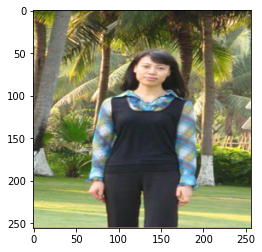

In [39]:
#Let us now compare it with a different image
show_img(tst_img2)

In [35]:
eval(tst_img2, orig_img1)

Unmatched
tensor(3.7858e-06, grad_fn=<MseLossBackward>)


In [40]:
tst_img3='/content/trainset/0001/0001_0000264/0000006.jpg'

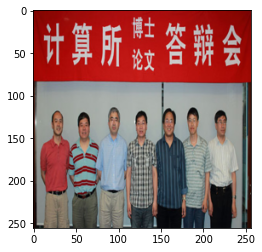

In [41]:
show_img(tst_img3)

In [42]:
eval(tst_img3, orig_img1) # because orig_img1 is present in this image

Matched
tensor(1.9867e-06, grad_fn=<MseLossBackward>)


In [43]:
scr='/content/trainset/0001/0001_0000264/0001_0000264_script.jpg'

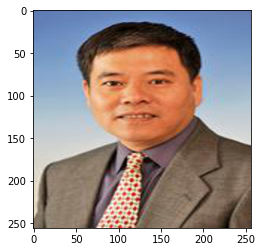

In [44]:
show_img(scr)

In [45]:
eval(tst_img3,scr) # THis guy is also present in the pic above

Matched
tensor(2.5433e-06, grad_fn=<MseLossBackward>)


In [46]:
tst_img4='/content/trainset/0003/0003_0000329/0003_0000329_script.jpg'

In [50]:
tst_img5='/content/trainset/0003/0003_0000329/0000005.jpg'

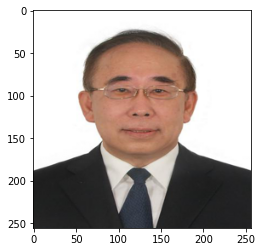

In [47]:
show_img(tst_img4)

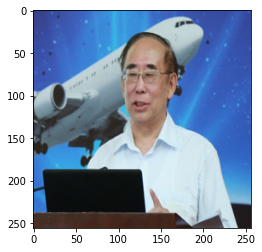

In [51]:
show_img(tst_img5)

In [59]:
eval(tst_img4,tst_img5)

Matched
tensor(2.7858e-06, grad_fn=<MseLossBackward>)


In [58]:
import os
for img in os.listdir('/content/trainset/0003/0003_0000329'):
  eval(tst_img4,'/content/trainset/0003/0003_0000329'+"/"+img)

# Most of the images matched


Matched
tensor(2.2213e-06, grad_fn=<MseLossBackward>)
Unmatched
tensor(5.2904e-06, grad_fn=<MseLossBackward>)
Matched
tensor(2.2208e-06, grad_fn=<MseLossBackward>)
Matched
tensor(2.7918e-06, grad_fn=<MseLossBackward>)
Matched
tensor(2.7858e-06, grad_fn=<MseLossBackward>)
Unmatched
tensor(3.5444e-06, grad_fn=<MseLossBackward>)
Matched
tensor(2.2854e-06, grad_fn=<MseLossBackward>)
Matched
tensor(2.7652e-06, grad_fn=<MseLossBackward>)
Matched
tensor(2.2854e-06, grad_fn=<MseLossBackward>)
Unmatched
tensor(3.2718e-06, grad_fn=<MseLossBackward>)
Matched
tensor(2.7918e-06, grad_fn=<MseLossBackward>)
Matched
tensor(0., grad_fn=<MseLossBackward>)


In [77]:
# Now let's define a function which will make visualisation easy
def match(im1,im2):

  img1 = Image.open(im1) # use pillow to open a file
  img1 = img1.resize((w, h)) # resize the file to 256x256
  img1 = img1.convert('RGB') #convert image to RGB channe
  img1 = np.asarray(img1)/255
  #same for image 2
  img2 = Image.open(im2) # use pillow to open a file
  img2 = img2.resize((w, h)) # resize the file to 256x256
  img2 = img2.convert('RGB') #convert image to RGB channe
  img2 = np.asarray(img2)/255

  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(img1)
  axarr[1].imshow(img2)
  plt.show()
  eval(im1,im2)

Unmatched
tensor(5.0084e-06, grad_fn=<MseLossBackward>)


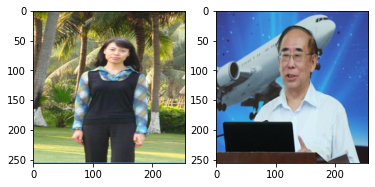

In [68]:
match(tst_img2,tst_img5)

Unmatched
tensor(3.2268e-06, grad_fn=<MseLossBackward>)


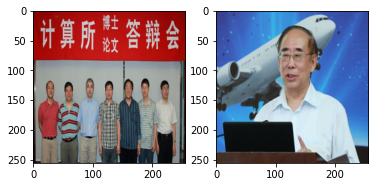

In [69]:
match(tst_img3,tst_img5)

Matched
tensor(2.7858e-06, grad_fn=<MseLossBackward>)


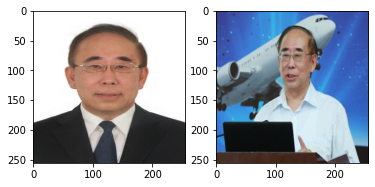

In [70]:
match(tst_img4,tst_img5)

Matched
tensor(2.5434e-06, grad_fn=<MseLossBackward>)


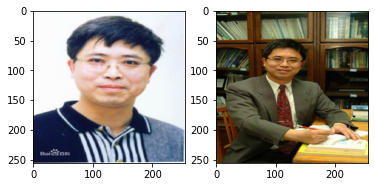

In [72]:
match(orig_img1,tst_img1)

Matched
tensor(1.4196e-06, grad_fn=<MseLossBackward>)


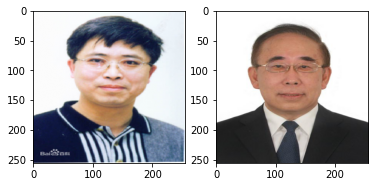

In [73]:
match(orig_img1,tst_img4) # Wrong prediction but they do looks like same

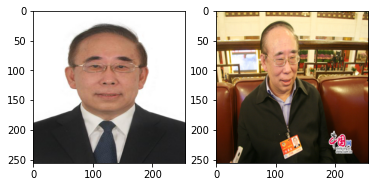

Matched 

tensor(2.2213e-06, grad_fn=<MseLossBackward>)




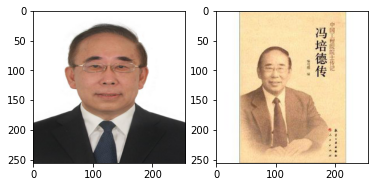

Unmatched 

tensor(5.2904e-06, grad_fn=<MseLossBackward>)




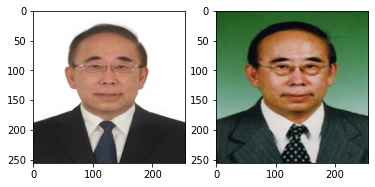

Matched 

tensor(2.2208e-06, grad_fn=<MseLossBackward>)




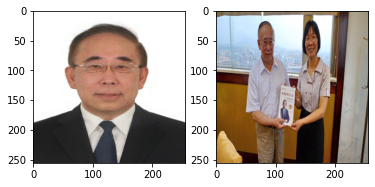

Matched 

tensor(2.7918e-06, grad_fn=<MseLossBackward>)




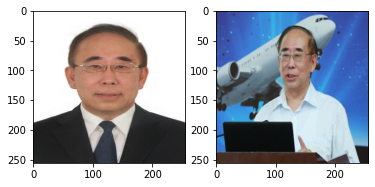

Matched 

tensor(2.7858e-06, grad_fn=<MseLossBackward>)




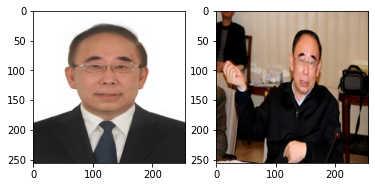

Unmatched 

tensor(3.5444e-06, grad_fn=<MseLossBackward>)




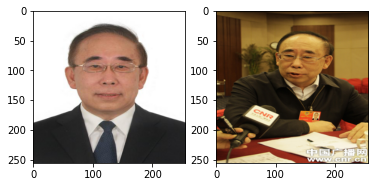

Matched 

tensor(2.2854e-06, grad_fn=<MseLossBackward>)




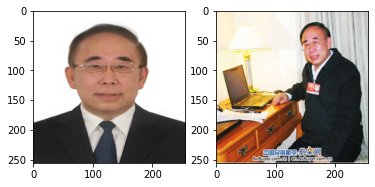

Matched 

tensor(2.7652e-06, grad_fn=<MseLossBackward>)




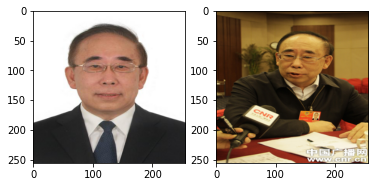

Matched 

tensor(2.2854e-06, grad_fn=<MseLossBackward>)




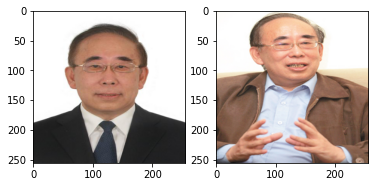

Unmatched 

tensor(3.2718e-06, grad_fn=<MseLossBackward>)




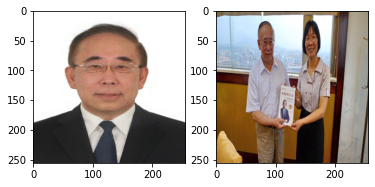

Matched 

tensor(2.7918e-06, grad_fn=<MseLossBackward>)




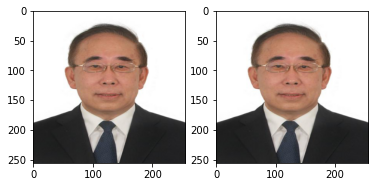

Matched 

tensor(0., grad_fn=<MseLossBackward>)




In [78]:
for img in os.listdir('/content/trainset/0003/0003_0000329'):
  match(tst_img4,'/content/trainset/0003/0003_0000329'+"/"+img)